### Model complexity: Effect of memorizing data on performance 
- Run NAVAR, NAVAR-WS, NAVAR-Rec on a complete random dataset (no causal connections)
- Show memorization plot
- Run NAVAR, NAVAR-WS, NAVAR-Rec, NAVAR-Dropout on (10, 2000, 5) with receptive field of 500 (deep model)


In [22]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
from src.models.NAVAR import NAVAR
from src.models.TAMCaD import TAMCaD
from src.training.train_model import train_model, train_test_split
from src.utils import smooth_line

In [63]:
dataset = {
    'name': 'random_N-5_T-800',
    'data': torch.randn(1, 3, 1400),
    'data_noise_adjusted': torch.zeros(1, 3, 1400)
}
model_params = {
    'default': {'gamma': 0.0, 'weight_sharing': False, 'recurrent': False, 'dropout': 0.0, 'use_gumbel': False, 'hidden_dim':32},
    'use_recurrent_layers': {'gamma': 0.0, 'weight_sharing': False, 'recurrent': True, 'dropout': 0.0, 'use_gumbel': False, 'hidden_dim':32},
    'use_weight_sharing': {'gamma': 0.0, 'weight_sharing': True, 'recurrent': False, 'dropout': 0.0, 'use_gumbel': False, 'hidden_dim':32},
    'use_ws_and_rec': {'gamma': 0.0, 'weight_sharing': True, 'recurrent': True, 'dropout': 0.0, 'use_gumbel': False, 'hidden_dim':32},
    'dropout_0.4': {'gamma': 0.0, 'weight_sharing': False, 'recurrent': False, 'dropout': 0.4, 'use_gumbel': False, 'hidden_dim':32},
    'hidden_dim_8': {'gamma': 0.0, 'weight_sharing': False, 'recurrent': False, 'dropout': 0.0, 'use_gumbel': False, 'hidden_dim':8},
    'all': {'gamma': 0.0, 'weight_sharing': True, 'recurrent': True, 'dropout': 0.4, 'use_gumbel': False, 'hidden_dim':8},
}

In [64]:
all_results = {}
for name, params in model_params.items():
    all_results[name] = train_model(
        experiment_name='memorization',
        experiment_run=name,
        dataset=dataset,
        model_type=TAMCaD,
        lr=1e-4,
        epochs=1000,
        weight_decay=1e-10,
        test_size=0.3,
        kernel_size=3,
        n_blocks=4,
        n_layers=2,
        **params
    )

[train] loss=0.05,noise=0.96 [test] loss=2.13,noise=1.10: 100%|████████████████████| 1000/1000 [00:13<00:00, 73.05it/s]
[train] loss=0.18,noise=0.82 [test] loss=1.98,noise=0.90: 100%|████████████████████| 1000/1000 [00:13<00:00, 74.70it/s]
[train] loss=0.09,noise=0.91 [test] loss=2.17,noise=1.09: 100%|████████████████████| 1000/1000 [00:12<00:00, 78.39it/s]
[train] loss=0.29,noise=0.70 [test] loss=1.98,noise=0.89: 100%|████████████████████| 1000/1000 [00:13<00:00, 76.82it/s]
[train] loss=1.03,noise=0.00 [test] loss=0.98,noise=0.00: 100%|████████████████████| 1000/1000 [00:14<00:00, 70.04it/s]
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\mauri\.conda\envs\causal-discovery\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:

In [65]:
table_data = []

# Iterate through each model's results
for model_name, result in all_results.items():
    # Extract desired metrics
    loss = round(result['train_metrics']['loss'][1][-1].item(), 3)
    num_params = result['model_params']['n_params']
    training_time_per_epoch = round(1000 * result['model_params']['training_time_per_epoch'], 1)
    receptive_field = result['model_params']['receptive_field']
    
    # Add a row to the table data
    table_data.append({
        "Model": model_name,
        "Loss": loss,
        "Number of Parameters": num_params,
        "Training Time per Epoch (ms)": training_time_per_epoch,
        "Receptive Field": receptive_field
    })

results_df = pd.DataFrame(table_data)

results_df.set_index("Model", inplace=True)

results_df.sort_values('Loss')

,Loss,Number of Parameters,Training Time per Epoch (ms),Receptive Field
Model,,,,
default,0.053,71436,13.7,61
use_weight_sharing,0.092,33804,12.8,61
use_recurrent_layers,0.181,33804,13.4,61
use_ws_and_rec,0.287,21260,13.0,61
hidden_dim_8,0.811,4908,13.4,61
dropout_0.4,1.026,71436,14.3,61
all,1.036,1580,13.5,61


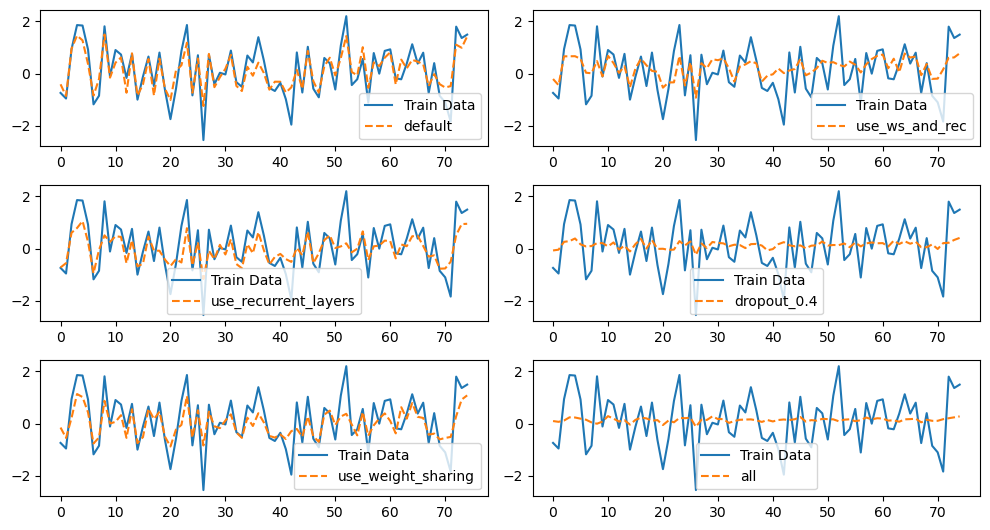

In [26]:
# Determine the number of models
num_models = len(all_results)

# Create a figure with subplots stacked vertically
fig, axes = plt.subplots(3, 2, figsize=(10, 0.9 * num_models))

# Check if there is only one model (axes would not be an array in this case)
if num_models == 1:
    axes = [axes]

train, _, _ = train_test_split(**dataset, test_size=0.3)

# Iterate through each model
for i, (model_name, result) in enumerate(all_results.items()):
    i_index = i % 3
    j_index = 0 if i < 3 else 1
    # Plot the training data
    axes[i_index, j_index].plot(result['train_data']['x'][0, 0, -75:].cpu(), label='Train Data')

    # Plot the prediction
    axes[i_index, j_index].plot(result['train_artifacts']['prediction'][0, -76:-1], label=model_name, linestyle='--')

    # Set the title and legend for each subplot
    axes[i_index, j_index].legend()


#axes[0].set_title('Various model architectures in TAMCaD')
plt.tight_layout()
plt.savefig('complexity_random_data.png', dpi=200)
plt.show()


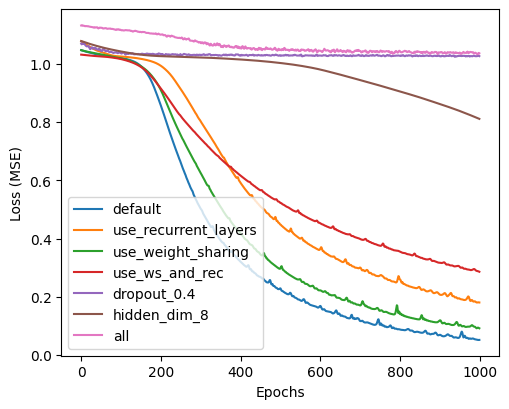

In [66]:

fig = plt.gcf()
fig.set_size_inches(5, 4)

# Iterate through each model
for i, (model_name, result) in enumerate(all_results.items()):
    #print(result['model_params']['receptive_field'])
    epochs, losses = result['train_metrics']['loss']
    losses = smooth_line(losses, sigma=1.0)
    plt.plot(epochs, losses, label=model_name)


#axes[0].set_title('Various model architectures in TAMCaD')
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('complexity_loss.png', dpi=200)
plt.show()
